#Carrega as bibliotecas do Python no Notebook

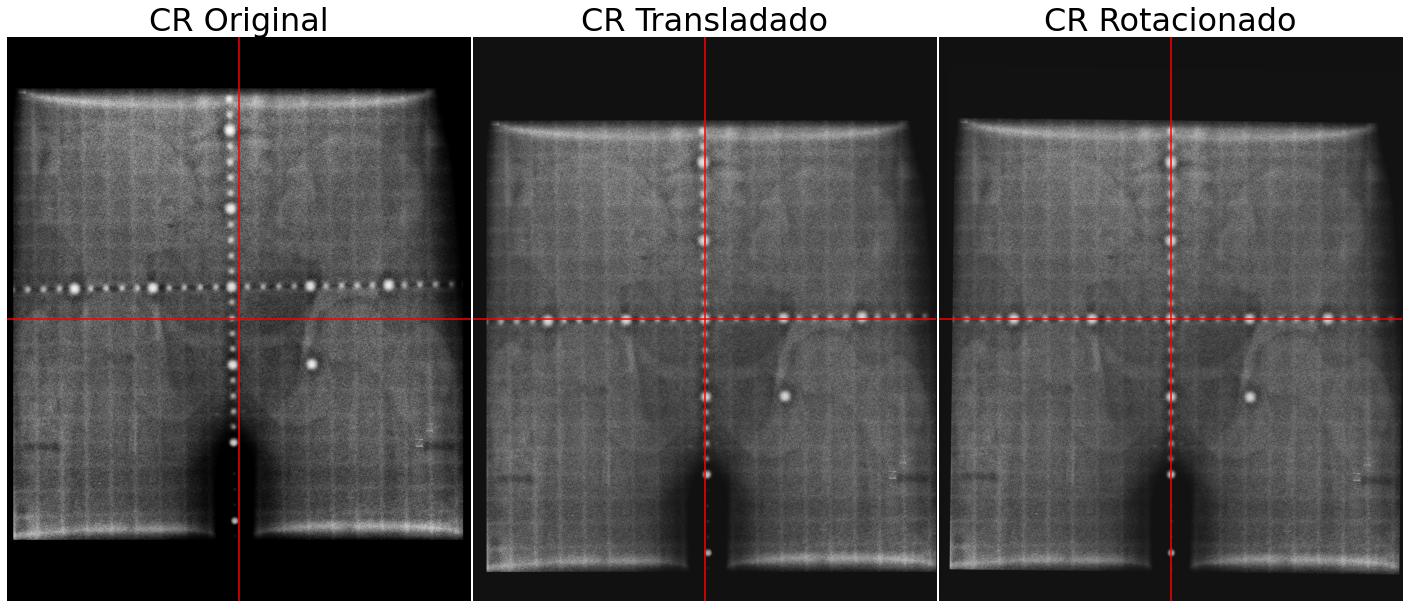

/tmp/ipykernel_72440/3019541477.py:186: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.005)  # This adds 5 pixels space between plots


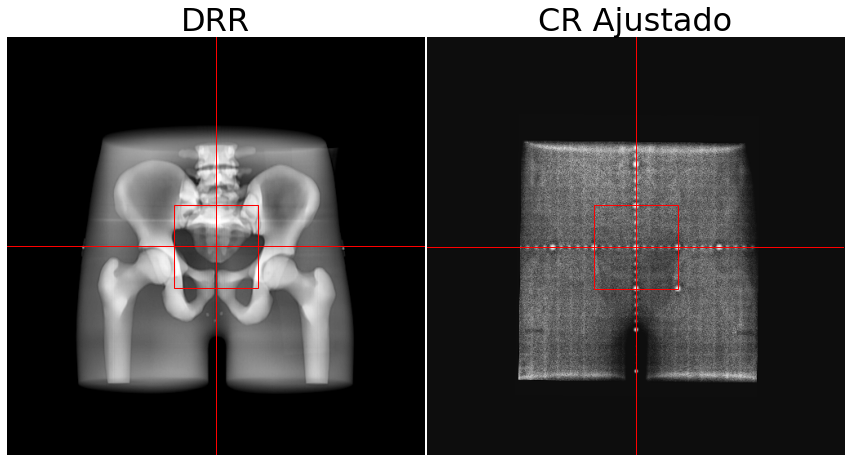

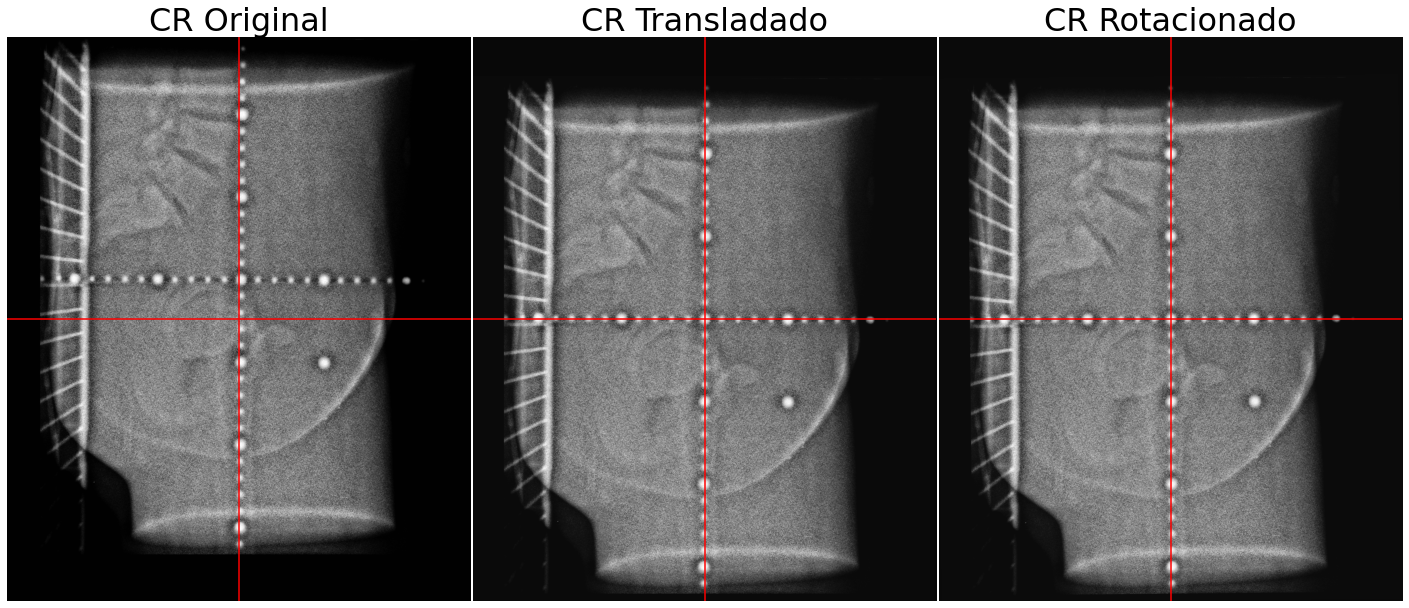

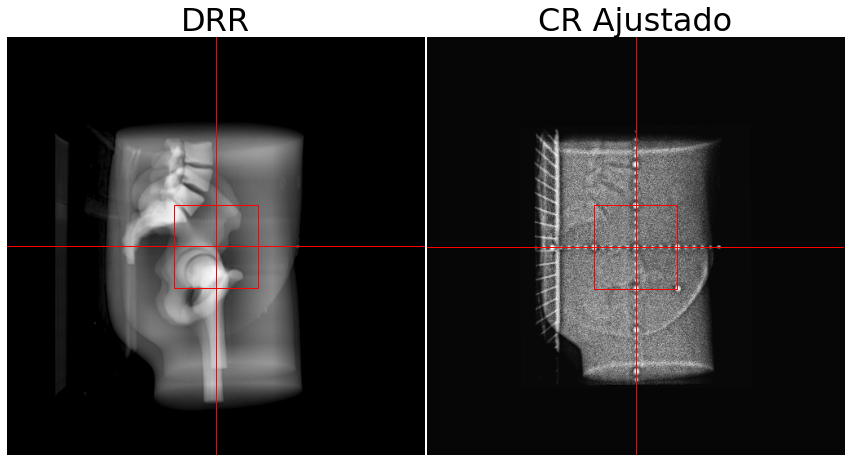

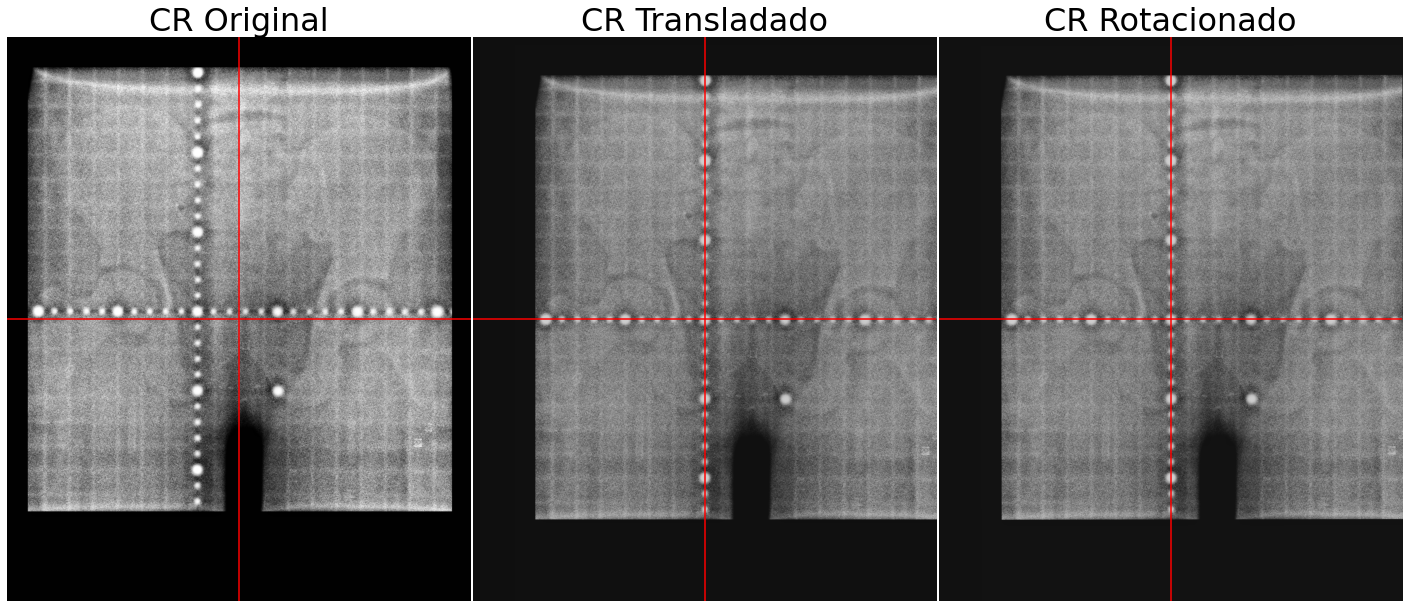

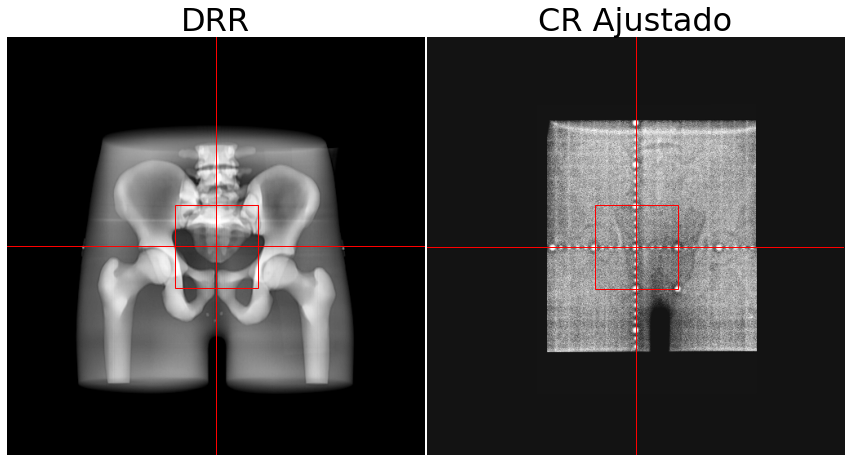

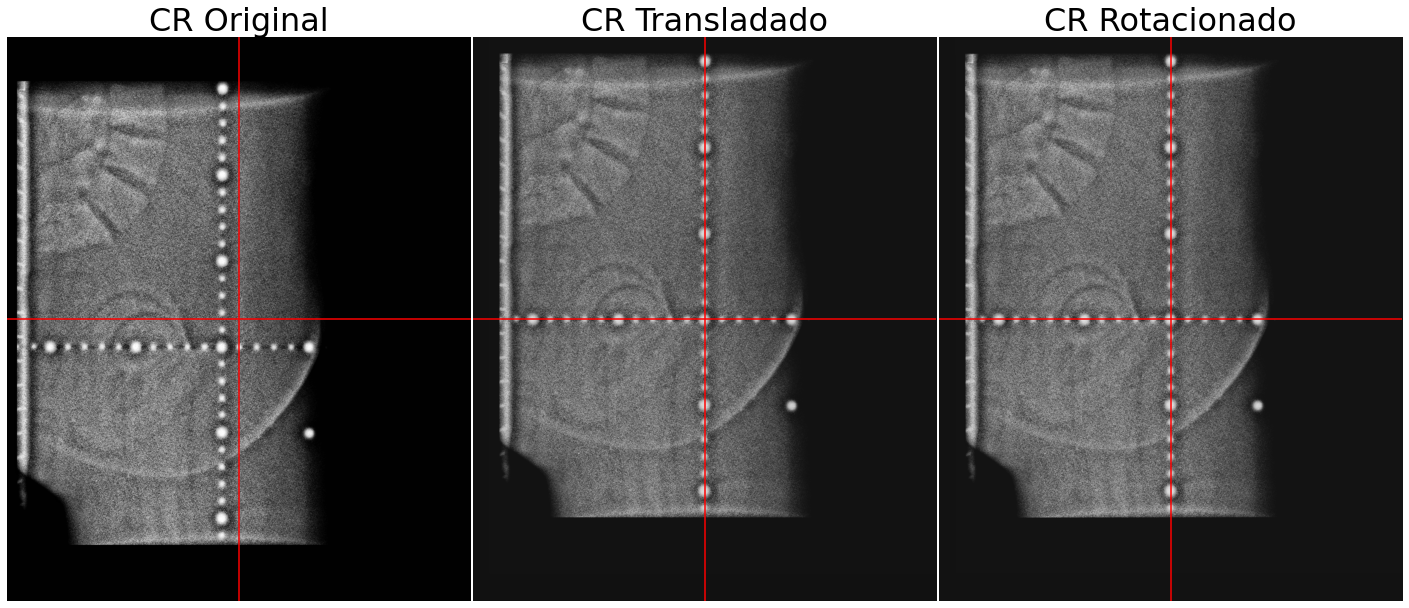

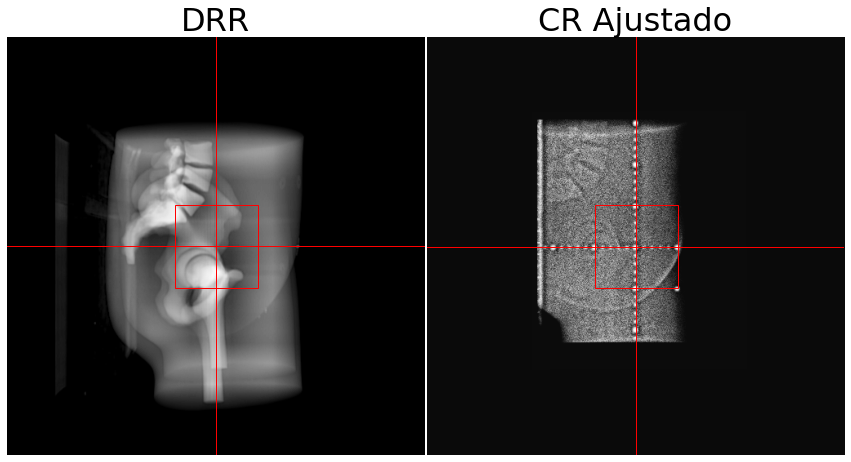

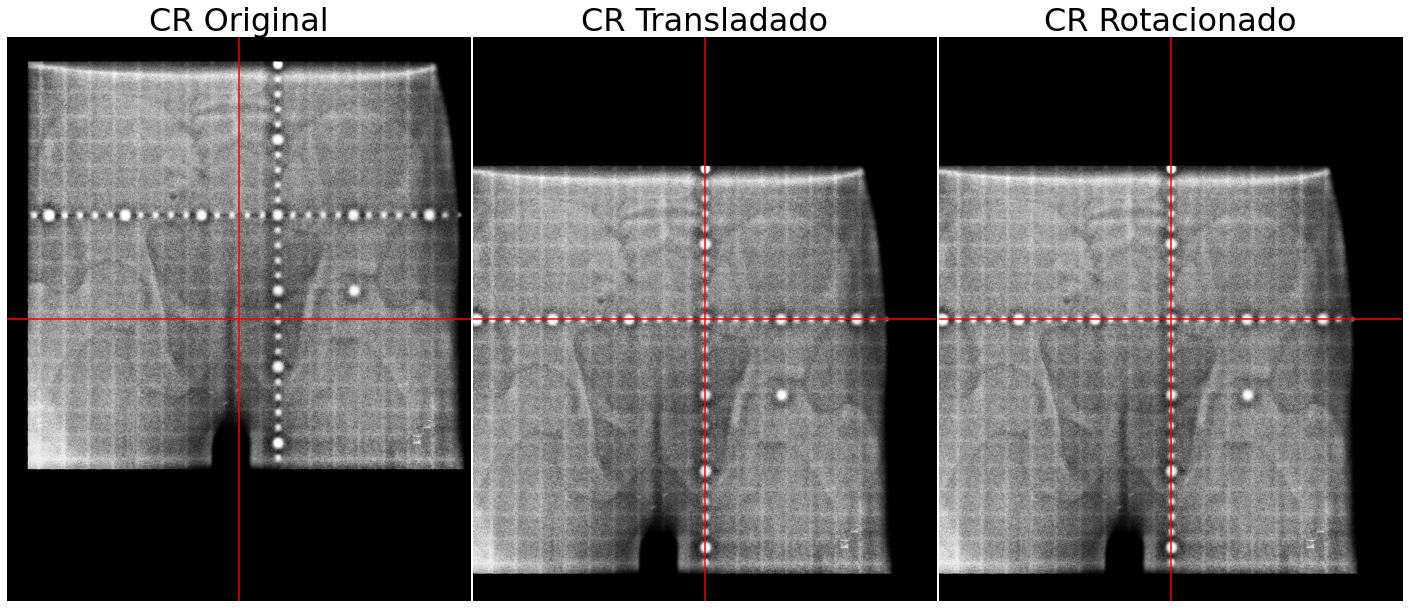

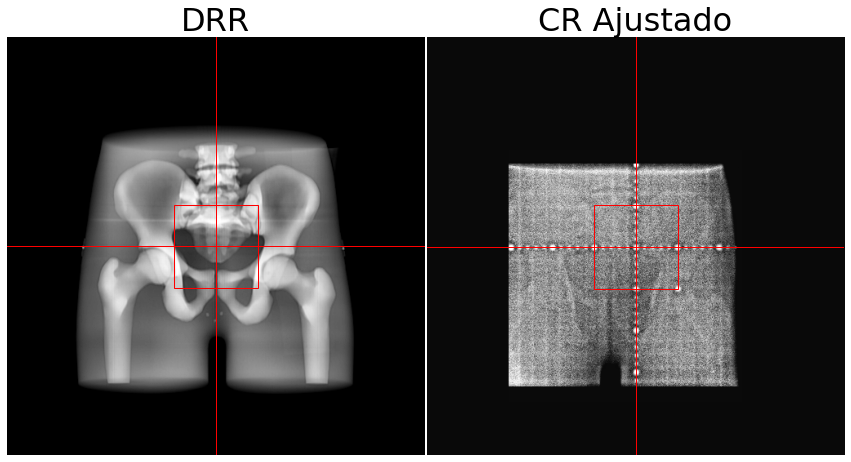

In [ ]:
#Carrega as bibliotecas do Python no Notebook
import os
import pydicom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import shift, rotate, zoom
import numpy as np
from PIL import Image
from skimage import filters, img_as_ubyte, exposure

def exposure_equalize_adapthist(imagem, kernel_size, clip_limit):
    if kernel_size == None:
        img_eq = exposure.equalize_adapthist(imagem, clip_limit=clip_limit)
    if clip_limit == None:
        img_eq = exposure.equalize_adapthist(imagem, kernel_size=kernel_size)
    else:
        img_eq = exposure.equalize_adapthist(imagem, kernel_size=50)
    return img_eq

def substituir_extensao(arquivo):
    nome_arquivo, extensao = os.path.splitext(arquivo)
    if extensao == '.dcm':
        novo_nome_arquivo = nome_arquivo + '.png'  
    return novo_nome_arquivo

#Função para ler a matriz de pixel da imagem dicom
def matrizpixel(imagem):
    #Matriz de pixel dicom
    matrizpixel = imagem.pixel_array
    interpretacao = propriedadeimage(imagem)
    #Fução para inverter matriz de pixel conforme a interpretacao dicom
    if interpretacao["interpretacao"] == 'MONOCHROME1':
        matrizpixel = np.max(matrizpixel) - matrizpixel
    return matrizpixel

def propriedadeimage(imagem):
    #Imagem DRR ou CR
    if imagem.Modality == 'RTIMAGE':
        #Propriedades dicom da imagem DRR
        resolucao = imagem.ImagePlanePixelSpacing # mm
        centro = imagem.RTImagePosition # mm
        sid = imagem.RTImageSID # mm
        tamanho = imagem.pixel_array.shape
        canais = imagem.pixel_array.shape[2] if len(imagem.pixel_array.shape) > 2 else 1
        bits = imagem.BitsStored
        interpretacao = imagem.PhotometricInterpretation
    else:
        #Propriedades dicom da imagem CR
        resolucao = imagem.ImagerPixelSpacing  # mm
        centro = '' #cr nao tem essa propriedade
        tamanho = imagem.pixel_array.shape  # pixel
        sid = '' #cr nao tem essa propriedade
        canais = imagem.pixel_array.shape[2] if len(imagem.pixel_array.shape) > 2 else 1
        bits = imagem.BitsStored
        interpretacao = imagem.PhotometricInterpretation
    #array das propriedades da imagem
    propriedadeimagem = {
        'resolucao': resolucao,
        'centro': centro,
        'tamanho': tamanho,
        'sid': sid,
        'canais': canais,
        'bits': bits,
        'interpretacao': interpretacao,
    }
    return propriedadeimagem

#Função paara ajustar a imagem reescalada para o formato alvo 512,512 sem alterar o centro
def ajusta_imagem(image, size=(512, 512)):
    # Garante que a imagem de entrada seja float64
    if image.dtype != np.float64:
        image = image.astype(np.float64)
    original_size = image.shape
    # Cria uma nova imagem preta do tamanho desejado
    final_image = np.zeros(size, dtype=np.float64)
    # Calcular offsets para o centro da imagem
    y_offset = (size[0] - original_size[0]) // 2
    x_offset = (size[1] - original_size[1]) // 2
    # Se a imagem é menor que o tamanho desejado, preenchemos.
    if original_size[0] <= size[0] and original_size[1] <= size[1]:
        final_image[y_offset:y_offset+original_size[0], x_offset:x_offset+original_size[1]] = image
    # Se a imagem é maior que o tamanho desejado, cortamos.
    if original_size[0] > size[0]:
        crop_y = (original_size[0] - size[0]) // 2
        image = image[crop_y:crop_y+size[0], :]
    if original_size[1] > size[1]:
        crop_x = (original_size[1] - size[1]) // 2
        image = image[:, crop_x:crop_x+size[1]]
    # Se a imagem é maior em uma dimensão e menor na outra, preenchemos após o corte.
    if original_size[0] <= size[0] and original_size[1] > size[1]:
        final_image[y_offset:y_offset+image.shape[0], :] = image
    if original_size[0] > size[0] and original_size[1] <= size[1]:
        final_image[:, x_offset:x_offset+image.shape[1]] = image
    return final_image

def processa_imagens(lista_imagens):
    for caminho_pasta, drr, cr, p1coluna, p2coluna, p1linha, p2linha in lista_imagens:  
        # Carregando o arquivo DICOM
        dcm_DRR = pydicom.dcmread(caminho_pasta+drr)
        # Carregando o arquivo DICOM do CR
        dcm_CR = pydicom.dcmread(caminho_pasta+cr)
        # Lendo as informações do DICOM DRR e CR
        DFFA = dcm_DRR.RTImageSID
        pixelA = dcm_DRR .ImagePlanePixelSpacing[0]
        centerA = (abs(dcm_DRR .RTImagePosition[0]), abs(dcm_DRR .RTImagePosition[1]) )
        Campo10A = DFFA / (10 * pixelA)
        sizeA = dcm_DRR.pixel_array.shape
        DFFB = 'calcular'  
        pixelB = dcm_CR.PixelSpacing[0]
        centerB = (abs(dcm_CR.pixel_array.shape[0]/2), abs(dcm_CR.pixel_array.shape[1]/2))
        Campo10B = "calcular"
        sizeB = dcm_CR.pixel_array.shape
        # Carregar a imagem DRR e DR
        image_DRR = matrizpixel(dcm_DRR)
        image_DRR = exposure_equalize_adapthist(image_DRR, kernel_size=50, clip_limit=None)
        image_CR = matrizpixel(dcm_CR)
        image_CR = exposure_equalize_adapthist(image_CR, kernel_size=50, clip_limit=None)
        # Pontos central
        novo_centro_linha = (p1linha + p2linha) / 2
        novo_centro_coluna = (p1coluna + p2coluna) / 2
        # Calcular o centro original da imagem
        centro_original_linha = image_CR.shape[0] / 2
        centro_original_coluna = image_CR.shape[1] / 2
        # Calcular o vetor de deslocamento
        deslocamento_linha = centro_original_linha - novo_centro_linha
        deslocamento_coluna = centro_original_coluna - novo_centro_coluna
        # Transladar a imagem
        image_CR_transladada = shift(image_CR, [deslocamento_linha, deslocamento_coluna])
        # Calcular o ângulo de rotação
        delta_y = p2linha - p1linha
        delta_x = p2coluna - p1coluna
        angulo_radianos = np.arctan2(delta_y, delta_x)
        angulo_graus = np.degrees(angulo_radianos)
        if angulo_graus < 0:
            angulo_graus += 180
        else:
            angulo_graus -= 180
        # Rotacionar a imagem
        image_CR_rotacionada = rotate(image_CR_transladada, angulo_graus, reshape=False)
        # Calcular a distância em pixels entre os pontos P1 e P2
        distancia_p1_p2 = np.sqrt((p2linha - p1linha)**2 + (p2coluna - p1coluna)**2)
        # Calcular o fator de escala necessário para que a distância entre P1 e P2 corresponda ao Campo10A do DRR
        fator_escala = Campo10A / distancia_p1_p2
        # Escalar a imagem
        image_CR_escalada = zoom(image_CR_rotacionada, fator_escala)
        # Calcular as coordenadas do centro da imagem escalada
        centro_escalado_coluna = centro_original_coluna * fator_escala
        centro_escalado_linha = centro_original_linha * fator_escala
        # Calcular as coordenadas do canto inferior esquerdo do quadrado
        canto_esquerdo_coluna = centro_escalado_coluna - Campo10A / 2
        canto_esquerdo_linha = centro_escalado_linha - Campo10A / 2
        # Cortar a imagem
        image_CR_escalada_cortada = ajusta_imagem(image_CR_escalada, size=(512, 512))
        #ajuste fino
        image_CR_escalada_cortada = shift(image_CR_escalada_cortada, [2, 0])
        # Calcular as novas coordenadas do centro e do quadrado
        centro_escalado_coluna_cortado = centro_escalado_coluna - (image_CR_escalada.shape[1] - 512) // 2
        centro_escalado_linha_cortado = centro_escalado_linha - (image_CR_escalada.shape[0] - 512) // 2
        canto_esquerdo_coluna_cortado = centro_escalado_coluna_cortado - Campo10A / 2
        canto_esquerdo_linha_cortado = centro_escalado_linha_cortado - Campo10A / 2
        # Criar a figura e os eixos
        fig, axs = plt.subplots(1, 3, figsize=(25, 15))
        plt.subplots_adjust(wspace=0.005)  # This adds 5 pixels space between plots
        # Mostrar a imagem original
        axs[0].imshow(image_CR, cmap='gray')
        axs[0].axvline(image_CR.shape[1]/2, color='red')
        axs[0].axhline(image_CR.shape[0]/2, color='red')
        axs[0].set_title("CR Original" , fontsize=32)
        axs[0].axis('off')
        # Mostrar a imagem transladada
        axs[1].imshow(image_CR_transladada, cmap='gray')
        axs[1].axvline(centro_original_coluna, color='red')
        axs[1].axhline(centro_original_linha, color='red')
        axs[1].set_title("CR Transladado" , fontsize=32)
        axs[1].axis('off')
        # Mostrar a imagem rotacionada
        axs[2].imshow(image_CR_rotacionada, cmap='gray')
        axs[2].axvline(centro_original_coluna, color='red')
        axs[2].axhline(centro_original_linha, color='red')
        axs[2].set_title("CR Rotacionado" , fontsize=32)
        axs[2].axis('off')
        # Mostrar a figura
        plt.show()
        # Mostrar a imagem DRR e CR ajustada
        fig, axs = plt.subplots(1, 2, figsize=(15, 15), constrained_layout=True)
        plt.subplots_adjust(wspace=0.005)  # This adds 5 pixels space between plots
        axs[0].imshow(image_DRR, cmap='gray')
        axs[0].axvline(255.5, color='red', linewidth=1)
        axs[0].axhline(255.5, color='red', linewidth=1)
        quadrado = Rectangle((canto_esquerdo_coluna_cortado-0.5, canto_esquerdo_linha_cortado-0.5), Campo10A, Campo10A, fill=False, edgecolor='red', linewidth=1)
        axs[0].add_patch(quadrado)
        axs[0].set_title("DRR" , fontsize=32)
        axs[0].axis('off')
        axs[1].imshow(image_CR_escalada_cortada, cmap='gray')
        axs[1].axvline(centro_escalado_coluna_cortado, color='red', linewidth=1)
        axs[1].axhline(centro_escalado_linha_cortado, color='red', linewidth=1)
        quadrado = Rectangle((canto_esquerdo_coluna_cortado, canto_esquerdo_linha_cortado), Campo10A, Campo10A, fill=False, edgecolor='red', linewidth=1)
        axs[1].add_patch(quadrado)
        axs[1].set_title("CR Ajustado", fontsize=32)
        axs[1].axis('off')
        plt.show()
        # Converte a matriz de pixel para dtype uint8 (8 bits por canal)
        image_CR_escalada_cortada = (image_CR_escalada_cortada / np.max(image_CR_escalada_cortada) * 255).astype(np.uint8)
        # Converte a matriz de pixel para dtype uint8 (8 bits por canal)
        image_DRR = (image_DRR / np.max(image_DRR) * 255).astype(np.uint8)
        # Salva a imagem CR em PNG
        imagem = Image.fromarray(image_CR_escalada_cortada)
        imagem = imagem.convert('L')
        imagem.save(substituir_extensao(caminho_pasta+cr))
        # Salva a imagem DRR em PNG
        imagem = Image.fromarray(image_DRR)
        imagem = imagem.convert('L')
        imagem.save(substituir_extensao(caminho_pasta+drr))

# Lista de imagens
lista_imagens = [
    (r'Par1_dcm/','DRR.0.dcm','CR.0.dcm',1151,554,945,952),
    (r'Par1_dcm/','DRR.270.dcm','CR.270.dcm',1204,573,924,918),
    (r'Par2_dcm/','DRR.0.dcm','CR.0.dcm',1026,419,1040,1039),
    (r'Par2_dcm/','DRR.270.dcm','CR.270.dcm',1147,488,1175,1174),
    (r'Par3_dcm/','DRR.0.dcm','CR.0.dcm',1315,737,674,674),
    (r'Par3_dcm/','DRR.270.dcm','CR.270.dcm',837,214,819,812),
]
processa_imagens(lista_imagens)

In [22]:
import cv2
import numpy as np
import pydicom

def traduzir_imagem(img, x, y):
    """
    Traduz uma imagem.

    Parâmetros:
        img (ndarray): A imagem original.
        x (int): A quantidade de pixels para transladar na horizontal.
        y (int): A quantidade de pixels para transladar na vertical.

    Retorna:
        ndarray: A imagem transladada.
    """
    altura, largura = img.shape[:2]
    matriz = np.float32([[1, 0, x], [0, 1, y]])
    return cv2.warpAffine(img, matriz, (largura, altura))

def rotacionar_imagem(img, angulo, centro=None, escala=1.0):
    """
    Rotaciona uma imagem.

    Parâmetros:
        img (ndarray): A imagem original.
        angulo (float): O ângulo de rotação.
        centro (tuple, opcional): O ponto central da rotação. Por padrão é None.
        escala (float, opcional): Fator de escala. Por padrão é 1.0.

    Retorna:
        ndarray: A imagem rotacionada.
    """
    altura, largura = img.shape[:2]
    if centro is None:
        centro = (largura // 2, altura // 2)
    matriz = cv2.getRotationMatrix2D(centro, angulo, escala)
    return cv2.warpAffine(img, matriz, (largura, altura))

def redimensionar_imagem(img, largura=None, altura=None, inter=cv2.INTER_AREA):
    """
    Redimensiona uma imagem mantendo sua proporção.

    Parâmetros:
        img (ndarray): A imagem original.
        largura (int, opcional): A nova largura desejada. Por padrão é None.
        altura (int, opcional): A nova altura desejada. Por padrão é None.
        inter (int, opcional): Método de interpolação. Por padrão é cv2.INTER_AREA.

    Retorna:
        ndarray: A imagem redimensionada.
    """
    dim = None
    (h, w) = img.shape[:2]
    if largura is None and altura is None:
        return img
    if largura is None:
        r = altura / float(h)
        dim = (int(w * r), altura)
    else:
        r = largura / float(w)
        dim = (largura, int(h * r))
    return cv2.resize(img, dim, interpolation=inter)

def load_dicom_image(path):
    """
    Carrega uma imagem DICOM e a converte em uma matriz numpy.
    
    Parâmetros:
        path (str): Caminho do arquivo DICOM.

    Retorna:
        ndarray: Imagem no formato numpy array.
    """
    dicom_file = pydicom.dcmread(path)
    image = dicom_file.pixel_array
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return image

def main(nome_arquivo):
    try:
        # Carregar a imagem
        if nome_arquivo.endswith('.dcm'):
            imagem = load_dicom_image(nome_arquivo)
        else:
            imagem = cv2.imread(nome_arquivo)
        
        if imagem is None:
            print("Erro ao carregar a imagem.")
            return

        # Realizar transformações
        imagem_transladada = traduzir_imagem(imagem, 50, 50)
        imagem_rotacionada = rotacionar_imagem(imagem, 45)
        imagem_redimensionada = redimensionar_imagem(imagem, largura=300)

        # Salvar imagens transformadas
        cv2.imwrite("imagem_transladada.jpg", imagem_transladada)
        cv2.imwrite("imagem_rotacionada.jpg", imagem_rotacionada)
        cv2.imwrite("imagem_redimensionada.jpg", imagem_redimensionada)

    except Exception as e:
        print(f"Ocorreu um erro: {e}")

if __name__ == "__main__":
    nome_arquivo = "Par1_dcm/CR.0.dcm"
    main(nome_arquivo)

In [26]:
import pydicom
dicom_file = pydicom.dcmread("Par1_dcm/CR.0.dcm")
image = dicom_file.pixel_array
print("tipo: ",image.dtype)

dicom_file2 = pydicom.dcmread("Par1_dcm/DRR.0.dcm")
image2 = dicom_file2.pixel_array
print("tipo2: ",image2.dtype)

tipo:  uint16
tipo2:  uint16


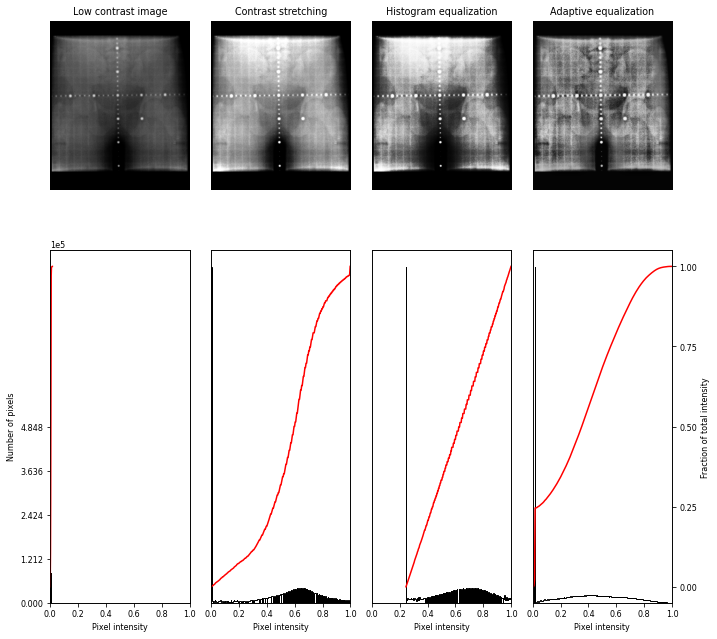

In [78]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img1 = pydicom.dcmread('Par1_dcm/CR.0.dcm')
img = matrizpixel(img1)

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(10, 10))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()